<h2>Download dataset from kaggle

In [1]:
import opendatasets as od

od.download('https://www.kaggle.com/datasets/gpiosenka/100-bird-species') # insert your kaggle username and key

100%|██████████| 1.96G/1.96G [03:12<00:00, 10.9MB/s]


<h2>Load data

In [1]:
import tensorflow as tf
import os

def load_data(
    batch_size: int = 32,
    image_size: tuple[int] = (224, 224),
    dir: str = '100-bird-species'
) -> list[tf.data.Dataset]:
    datasets = []
    for dataset_type in ['train', 'test', 'valid']:
        datasets.append(
            tf.keras.preprocessing.image_dataset_from_directory(
                os.path.join(dir, dataset_type),
                labels='inferred',
                label_mode='categorical',
                image_size=image_size,
                batch_size=batch_size
            )
        )
    return datasets

train_data, test_data, valid_data = load_data()

2024-02-03 00:58:45.123331: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-03 00:58:45.123454: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-03 00:58:45.185744: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-03 00:58:45.311266: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-03 00:58:46.829558: W tensorflow/compiler/tf2

Found 84635 files belonging to 525 classes.


2024-02-03 00:58:52.964797: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-03 00:58:53.177161: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-03 00:58:53.177531: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Found 2625 files belonging to 525 classes.
Found 2625 files belonging to 525 classes.


<h2>Define model

In [2]:
base_model = tf.keras.applications.inception_resnet_v2.InceptionResNetV2(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3),
)
base_model.trainable = False

data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.1),
])

preprocess_input = tf.keras.applications.inception_resnet_v2.preprocess_input
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(525, activation='softmax')

inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.1)(x)
outputs = prediction_layer(x)

model = tf.keras.Model(inputs, outputs)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

<h2> Train model

In [ ]:
cache_size = len(train_data) // 10
cached_dataset = train_data.take(cache_size).cache()
non_cached_dataset = train_data.skip(cache_size)
train_data = cached_dataset.concatenate(non_cached_dataset)
valid_data = valid_data.prefetch(buffer_size=tf.data.AUTOTUNE)

# early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, mode='min', restore_best_weights=True)

history = model.fit(
    train_data,
    validation_data=valid_data,
    epochs=10,
    # callbacks=[early_stopping]
)


<Axes: >

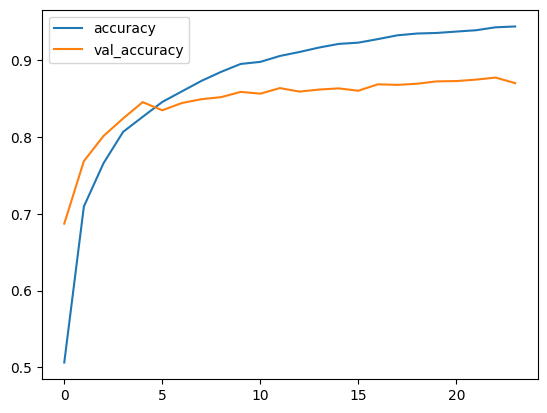

In [3]:
import pandas as pd


model.evaluate(test_data)
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot()

Found 2625 files belonging to 525 classes.
1/1 [==============================] - 0s 132ms/step


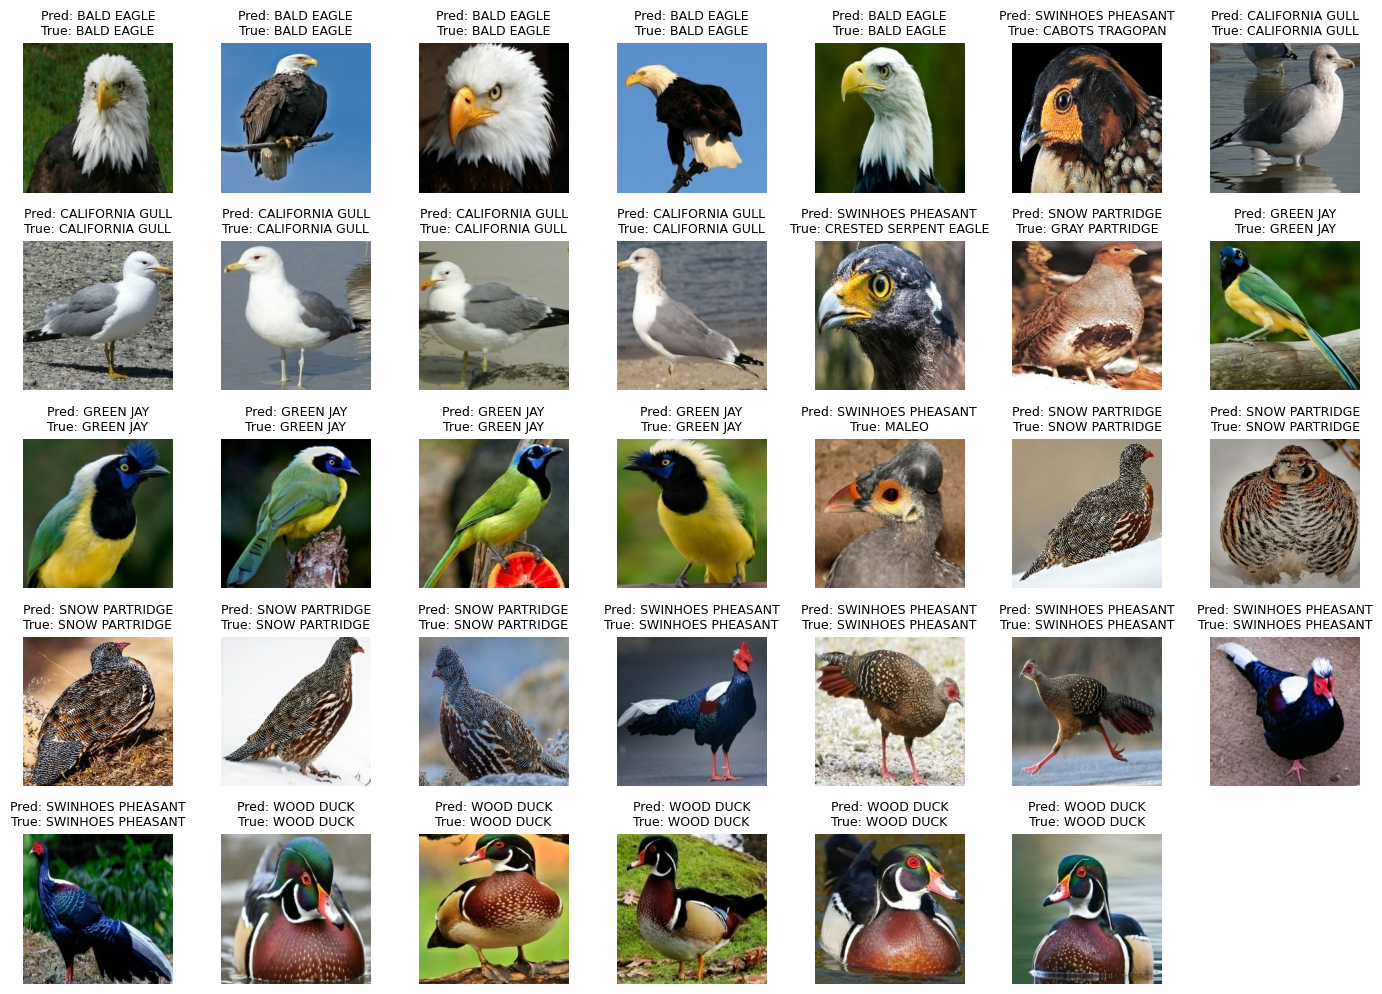

In [17]:
import matplotlib.pyplot as plt
import numpy as np

# Load the original dataset
original_test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    '100-bird-species/test',
    labels='inferred',
    label_mode='categorical',
    image_size=(224, 224),
    batch_size=8,
    shuffle=False
)

# Save the class names
label_names = original_test_dataset.class_names

# Preprocess the dataset for prediction
preprocess_input = tf.keras.applications.inception_resnet_v2.preprocess_input
test_dataset = original_test_dataset.map(lambda x, y: (preprocess_input(x), y)).prefetch(buffer_size=tf.data.AUTOTUNE)

def plot_images_with_predictions_concatenated(original_dataset, processed_dataset, model, num_batches=5, num_images_per_batch=8):
    total_images = num_batches * num_images_per_batch
    grid_size = int(total_images ** 0.5) + 1
    plt.figure(figsize=(grid_size * 2, grid_size * 2))
    image_count = 0

    # Iterate over both original and preprocessed datasets
    for (original_images, original_labels), (processed_images, labels) in zip(original_dataset, processed_dataset):
        predictions = model.predict(processed_images)
        
        for i in range(min(num_images_per_batch, len(original_images))):
            if image_count >= total_images:
                break

            predicted_index = tf.argmax(predictions[i], axis=-1).numpy()
            predicted_label = label_names[predicted_index]
            if predicted_label not in ('CALIFORNIA GULL', 'GREEN JAY', 'BALD EAGLE', 'WOOD DUCK', 'TAKAHE', 'SNOW PARTRIDGE', 'SWINHOES PHEASANT', 'MALLARD'):
                continue
            ax = plt.subplot(grid_size, grid_size, image_count + 1)
            plt.imshow(original_images[i].numpy().astype("uint8"))

            true_index = tf.argmax(labels[i], axis=-1).numpy() if len(labels[i].shape) > 0 else labels[i]
            true_label = label_names[true_index]

            plt.title(f"Pred: {predicted_label}\nTrue: {true_label}", fontsize=9)
            plt.axis("off")
            image_count += 1

        if image_count >= total_images:
            break

    plt.tight_layout()
    plt.savefig('plot.png')
    plt.show()

plot_images_with_predictions_concatenated(original_test_dataset, test_dataset, model)
